In [22]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller 
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
mt5.initialize()

# Replace following with your MT5 Account Login
account=51434456 # 
password="9UpBvVzc"
server = 'ICMarkets-Demo'

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def get_rates(pair1, timeframe, x):
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, timeframe, 0, x))
    pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
    return pair1[['time','open', 'high', 'low', 'close']].set_index('time')

def compute_spread(p1, p2, tf, x):
    data1 = get_rates(p1, tf, x)
    data2 = get_rates(p2, tf, x)
    merged = data1.join(data2, lsuffix="_x", rsuffix="_y")
    spread = merged['close_x'] - merged['close_y']
    return spread.dropna()

def adf_test(spread):
    '''Runs ADF test on a spread series'''
    result = adfuller(spread)
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}


In [5]:
get_rates('AUDUSD.a', mt5.TIMEFRAME_H1, 50)

,open,high,low,close
time,,,,
2023-11-13 08:00:00,0.63636,0.63676,0.63622,0.63653
2023-11-13 09:00:00,0.63650,0.63765,0.63630,0.63728
2023-11-13 10:00:00,0.63726,0.63739,0.63647,0.63724
2023-11-13 11:00:00,0.63725,0.63850,0.63724,0.63756
2023-11-13 12:00:00,0.63756,0.63798,0.63737,0.63788
2023-11-13 13:00:00,0.63788,0.63793,0.63727,0.63747
2023-11-13 14:00:00,0.63747,0.63755,0.63676,0.63738
2023-11-13 15:00:00,0.63739,0.63757,0.63655,0.63678
2023-11-13 16:00:00,0.63680,0.63698,0.63621,0.63647


In [9]:
EURUSD = get_rates('EURUSD.a', mt5.TIMEFRAME_H4, 10000)
GBPUSD = get_rates('GBPUSD.a', mt5.TIMEFRAME_H4, 10000)

combined_df = pd.concat([EURUSD['close'].rename('EURUSD_close'),
                         GBPUSD['close'].rename('GBPUSD_close')], axis=1)

## Correlation

<Axes: xlabel='time'>

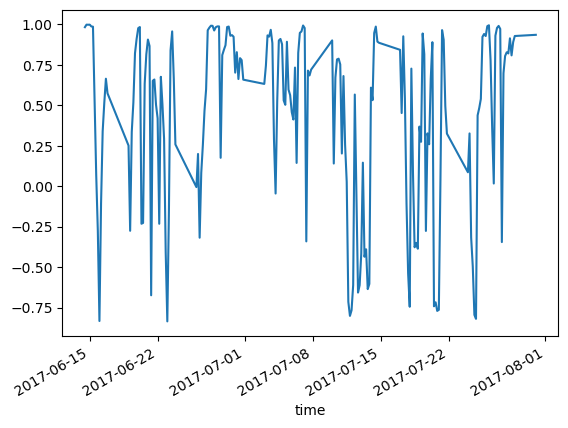

In [10]:
window_size = 5  # Change this to the size of the window you want
combined_df['rolling_corr'] = combined_df['EURUSD_close'].rolling(window=window_size).corr(combined_df['GBPUSD_close'])
combined_df['rolling_corr'].iloc[0:200].plot()

In [28]:
combined_df

,EURUSD_close,GBPUSD_close,rolling_corr,EURUSD_return,GBPUSD_return,diff,rolling_corr_returns,spread
time,,,,,,,,
2017-06-15 04:00:00,1.12215,1.27465,0.987676,0.000267,-0.000447,0.000714,-0.697284,-0.15250
2017-06-15 08:00:00,1.11797,1.27055,0.986418,-0.003725,-0.003217,-0.000508,-0.228702,-0.15258
2017-06-15 12:00:00,1.11520,1.27393,0.544097,-0.002478,0.002660,-0.005138,0.927734,-0.15873
2017-06-15 16:00:00,1.11483,1.27576,0.071834,-0.000332,0.001436,-0.001768,0.554284,-0.16093
2017-06-15 20:00:00,1.11450,1.27552,-0.274890,-0.000296,-0.000188,-0.000108,0.090272,-0.16102
...,...,...,...,...,...,...,...,...
2023-11-14 16:00:00,1.08730,1.24926,0.997716,0.007758,0.007330,0.000428,-0.498460,-0.16196
2023-11-14 20:00:00,1.08787,1.24981,0.998054,0.000524,0.000440,0.000084,-0.143271,-0.16194
2023-11-15 00:00:00,1.08719,1.24846,0.997799,-0.000625,-0.001080,0.000455,0.342792,-0.16127


In [27]:
combined_df = combined_df.dropna()
grangercausalitytests(combined_df[['rolling_corr', 'diff']], 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5074  , p=0.4763  , df_denom=9988, df_num=1
ssr based chi2 test:   chi2=0.5075  , p=0.4762  , df=1
likelihood ratio test: chi2=0.5075  , p=0.4762  , df=1
parameter F test:         F=0.5074  , p=0.4763  , df_denom=9988, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1995  , p=0.8191  , df_denom=9985, df_num=2
ssr based chi2 test:   chi2=0.3993  , p=0.8190  , df=2
likelihood ratio test: chi2=0.3993  , p=0.8190  , df=2
parameter F test:         F=0.1995  , p=0.8191  , df_denom=9985, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1927  , p=0.9014  , df_denom=9982, df_num=3
ssr based chi2 test:   chi2=0.5785  , p=0.9013  , df=3
likelihood ratio test: chi2=0.5785  , p=0.9013  , df=3
parameter F test:         F=0.1927  , p=0.9014  , df_denom=9982, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7319  , p=0.

{1: ({'ssr_ftest': (0.5073624254388938, 0.47629951432642825, 9988.0, 1),
   'ssr_chi2test': (0.5075148170364425, 0.476216656269689, 1),
   'lrtest': (0.5075019273062935, 0.47622225678827557, 1),
   'params_ftest': (0.5073624254390161, 0.47629951432642825, 9988.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.1995363262166937, 0.8191137311732646, 9985.0, 2),
   'ssr_chi2test': (0.39927248851372454, 0.8190286252645722, 2),
   'lrtest': (0.39926450982602546, 0.8190318926578984, 2),
   'params_ftest': (0.1995363262171645, 0.8191137311732646, 9985.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.19270062652699999, 0.9014238575826496, 9982.0, 3),
   'ssr_chi2test': (0.5785072806185743, 0.9013345250421875, 3),
   'lrtest': (0.5784905293076008, 0.9013383312342245, 3),
   'params_ftest': (0.19270062652709474, 0.9014238575826496, 9982.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [

<Axes: xlabel='time'>

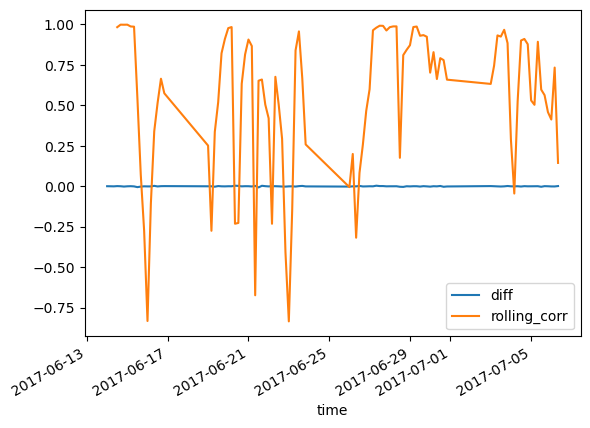

In [17]:
combined_df['spread'] = combined_df['EURUSD_close'] - combined_df['GBPUSD_close']
combined_df[['diff', 'rolling_corr']].iloc[0:100].plot()

In [11]:
combined_df['EURUSD_return'] = combined_df['EURUSD_close'].pct_change()
combined_df['GBPUSD_return'] = combined_df['GBPUSD_close'].pct_change()
combined_df['diff'] = combined_df['EURUSD_return'] - combined_df['GBPUSD_return']
combined_df['rolling_corr_returns'] = combined_df['rolling_corr'].rolling(window=window_size).corr(combined_df['diff'])
adf_test(combined_df['rolling_corr_returns'].dropna())

{'ADF Statistic': -33.5637703406132,
 'p-value': 0.0,
 'Critical Values': {'1%': -3.4310050808130597,
  '5%': -2.8618295067038217,
  '10%': -2.56692409928112}}

<Axes: xlabel='time'>

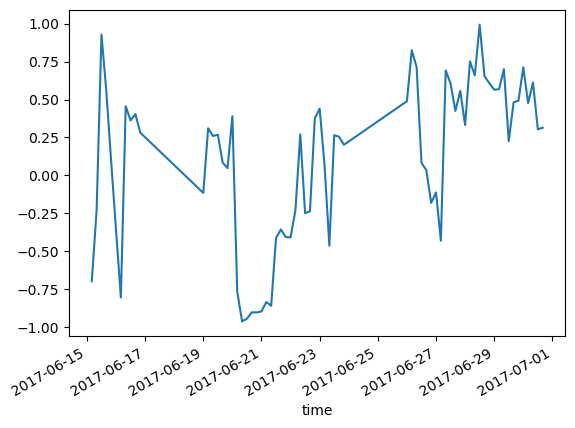

In [12]:
combined_df['rolling_corr_returns'].iloc[8:78].plot()

In [9]:
EU_GU = combined_df

In [108]:
def calc_hedge_ratio(x, y):
    Model2 = sm.OLS(x, y)
    Hedge_Ratio2 = Model2.fit()
    hedge_ratio_float2 = round(Hedge_Ratio2.params[0], 2)
    return hedge_ratio_float2


In [111]:
eu = get_rates('EURUSD.a', mt5.TIMEFRAME_H4, 1500)
gu = get_rates('GBPUSD.a', mt5.TIMEFRAME_H4, 1500)
import statsmodels.api as sm
calc_hedge_ratio(eu['close'], gu['close'])

0.87

# Granger Causality

In [ ]:
import granger_da

In [773]:
def get_pair_correlations(symbol1, symbol2, window, CSS_sym1, CSS_sym2):
    # css = corresponding symbol spread. Getting the yen equivalent essentially.
    s1 = str(symbol1)
    s2 = str(symbol2)
    # print(symbol1)
    symbol1 = get_rates(s1, mt5.TIMEFRAME_D1, 2000)
    symbol2 = get_rates(s2, mt5.TIMEFRAME_D1, 2000)

    combined_df = pd.concat([symbol1['close'].rename(f'{s1}_close'),
                            symbol2['close'].rename(f'{s2}_close')], axis=1)
    
    window_size = window  # Change this to the size of the window you want
    combined_df['rolling_corr'] = combined_df[f'{s1}_close'].rolling(window=window_size).corr(combined_df[f'{s2}_close'])
    combined_df['spread'] = combined_df[f'{s1}_close'] - combined_df[f'{s2}_close'] 
    combined_df[f'{s1}_return'] = combined_df[f'{s1}_close'].pct_change()
    combined_df[f'{s2}_return'] = combined_df[f'{s2}_close'].pct_change()
    combined_df['diff'] = combined_df[f'{s1}_return'] - combined_df[f'{s2}_return']
    combined_df['rolling_corr_returns'] = combined_df['rolling_corr'].rolling(window=window_size).corr(combined_df['diff'])
    combined_df['rolling_var'] = combined_df['spread'].rolling(window = 25).var()
    combined_df['MA_Ratio'] = combined_df['spread'].rolling(window = 15).mean() / combined_df['spread'].rolling(window = 75).mean()
    
    css1 = str(CSS_sym1)
    css2 = str(CSS_sym2)
    
    css_sym1 = get_rates(css1, mt5.TIMEFRAME_D1, 2000)
    css_sym2 = get_rates(css2, mt5.TIMEFRAME_D1, 2000)
    
    combined_df[f'{css1}_close'] = css_sym1['close']
    combined_df[f'{css2}_close'] = css_sym2['close']
    
    combined_df['CSS_spread'] = combined_df[f'{css1}_close'] - combined_df[f'{css2}_close']
    combined_df[f'{css1}_return'] = combined_df[f'{css1}_close'].pct_change()
    combined_df[f'{css2}_return'] = combined_df[f'{css2}_close'].pct_change()
    combined_df['CSS_diff'] = combined_df[f'{css1}_return'] - combined_df[f'{css2}_return']
    combined_df['CSS_rolling_corr_returns'] = combined_df['rolling_corr'].rolling(window=window_size).corr(combined_df['CSS_diff'])
    combined_df['CSS_rolling_var'] = combined_df['CSS_spread'].rolling(window = 25).var()
    combined_df['CSS_MA_Ratio'] = combined_df['CSS_spread'].rolling(window = 15).mean() / combined_df['spread'].rolling(window = 75).mean()
    
    combined_df.fillna(method = 'bfill', inplace = True)
    
    return combined_df

### EURUSD GBPUSD

In [751]:
EU_GU = get_pair_correlations('EURUSD.a', 'GBPUSD.a', 5, 'EURJPY.a', 'GBPJPY.a')

In [752]:
EU_GU.head(2)

,EURUSD.a_close,GBPUSD.a_close,rolling_corr,spread,EURUSD.a_return,GBPUSD.a_return,diff,rolling_corr_returns,rolling_var,MA_Ratio,EURJPY.a_close,GBPJPY.a_close,CSS_spread,EURJPY.a_return,GBPJPY.a_return,CSS_diff,CSS_rolling_corr_returns,CSS_rolling_var,CSS_MA_Ratio
time,,,,,,,,,,,,,,,,,,,
2020-08-31 04:00:00,1.19012,1.33377,0.653412,-0.14365,0.00058,-0.001754,0.002334,-0.598495,0.000011,0.813907,125.762,140.940,-15.178,0.002592,0.000263,0.00233,-0.608771,0.130534,85.927958
2020-08-31 08:00:00,1.19081,1.33143,0.653412,-0.14062,0.00058,-0.001754,0.002334,-0.598495,0.000011,0.813907,126.088,140.977,-14.889,0.002592,0.000263,0.00233,-0.608771,0.130534,85.927958


In [753]:
from statsmodels.tsa.stattools import grangercausalitytestas
grangercausalitytests(EU_GU[['spread', 'EURUSD.a_close']], 15)

ImportError: cannot import name 'grangercausalitytestas' from 'statsmodels.tsa.stattools' (C:\Users\mpaje352\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py)

In [658]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [659]:
granger_df = pd.DataFrame()

for i in range (1, 7):
    granger_df[f'Shifted Period {i}'] = EU_GU['spread'].shift(i)

granger_df['2w'] = EU_GU['spread'].rolling(window = 14).mean()
granger_df['1m'] = EU_GU['spread'].rolling(window = 30).mean()

for i in range(1,4):
    granger_df[f'MA_Ratio_{i}'] = EU_GU['MA_Ratio'].shift(i)

for i in range(6, 9):
    granger_df[f'rolling_corr_ret_{i}'] = EU_GU['rolling_corr_returns'].shift(i)

granger_df['rolling_var_3'] = EU_GU['rolling_var'].shift(3)
granger_df['rolling_var_4'] = EU_GU['rolling_var'].shift(4)
granger_df['spread'] = EU_GU['spread']

for i in range(1, 6):
    granger_df[f'CSS_MA_RATIO_{i}'] = EU_GU['CSS_MA_Ratio'].shift(i)
    granger_df[f'CSS_diff_{i}'] = EU_GU['CSS_diff'].shift(i)

for i in range(3, 6):
    granger_df[f'CSS_spread_{i}'] = EU_GU['CSS_spread'].shift(i)

for i in range(6, 10):
    granger_df[f'CSS_spread_{i}'] = EU_GU['CSS_spread'].shift(i)

for i in range(5, 10):
    granger_df[f'CSS_rolling_var_{i}'] = EU_GU['CSS_rolling_var'].shift(i)

for i in range(5, 10):
    granger_df[f'CSS_rolling_corr_returns_{i}'] = EU_GU['CSS_rolling_corr_returns'].shift(i)
    
granger_df = granger_df.dropna()

In [123]:
df_normalized = pd.DataFrame(scaler.fit_transform(granger_df), columns=granger_df.columns, index=granger_df.index)
df_normalized['spread'] = EU_GU['spread']
df_normalized

,Shifted Period 1,Shifted Period 2,Shifted Period 3,Shifted Period 4,Shifted Period 5,Shifted Period 6,2w,1m,MA_Ratio_1,MA_Ratio_2,...,CSS_rolling_var_5,CSS_rolling_var_6,CSS_rolling_var_7,CSS_rolling_var_8,CSS_rolling_var_9,CSS_rolling_corr_returns_5,CSS_rolling_corr_returns_6,CSS_rolling_corr_returns_7,CSS_rolling_corr_returns_8,CSS_rolling_corr_returns_9
time,,,,,,,,,,,,,,,,,,,,,
2020-09-17 04:00:00,0.786866,0.790864,0.794862,0.809870,0.860663,0.857714,0.983708,0.999004,0.186466,0.153956,...,0.041895,0.060405,0.080452,0.102448,0.126710,0.726986,0.457652,0.212072,0.400942,0.772184
2020-09-17 08:00:00,0.781426,0.786866,0.790864,0.794862,0.809870,0.860663,0.973003,0.999692,0.220805,0.186466,...,0.027692,0.041895,0.060405,0.080452,0.102448,0.366179,0.726986,0.457652,0.212072,0.400942
2020-09-17 12:00:00,0.787587,0.781426,0.786866,0.790864,0.794862,0.809870,0.967195,1.000000,0.257164,0.220805,...,0.035187,0.027692,0.041895,0.060405,0.080452,0.426778,0.366179,0.726986,0.457652,0.212072
2020-09-17 16:00:00,0.843754,0.787587,0.781426,0.786866,0.790864,0.794862,0.960566,0.996180,0.284186,0.257164,...,0.047150,0.035187,0.027692,0.041895,0.060405,0.418979,0.426778,0.366179,0.726986,0.457652
2020-09-17 20:00:00,0.814065,0.843754,0.787587,0.781426,0.786866,0.790864,0.954152,0.992690,0.317412,0.284186,...,0.059602,0.047150,0.035187,0.027692,0.041895,0.419762,0.418979,0.426778,0.366179,0.726986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-07 08:00:00,0.481452,0.478241,0.479093,0.473260,0.465657,0.463101,0.539626,0.540825,0.735893,0.729455,...,0.026188,0.027627,0.025208,0.023970,0.021728,0.601219,0.383789,0.274501,0.239050,0.064541
2023-11-07 12:00:00,0.483681,0.481452,0.478241,0.479093,0.473260,0.465657,0.536773,0.538427,0.739245,0.735893,...,0.024311,0.026188,0.027627,0.025208,0.023970,0.920276,0.601219,0.383789,0.274501,0.239050
2023-11-07 16:00:00,0.480600,0.483681,0.481452,0.478241,0.479093,0.473260,0.535200,0.537675,0.744111,0.739245,...,0.024956,0.024311,0.026188,0.027627,0.025208,0.862727,0.920276,0.601219,0.383789,0.274501


### All pairs

In [774]:
tests = ['ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest'] 

In [775]:
from statsmodels.tsa.stattools import adfuller 
def adf_test(spread):
    '''Runs ADF test on a spread series'''
    result = adfuller(spread)
    return {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}

In [776]:
currency_pairs = [
    ('EURUSD', 'GBPUSD', 'EURJPY', 'GBPJPY'),
    ('USDCAD', 'AUDCAD', 'CADJPY', 'AUDJPY'),
    ('USDCAD', 'NZDCAD', 'CADJPY', 'NZDJPY'),
    ('EURCHF', 'GBPCHF', 'CHFJPY', 'EURJPY'),
    ('EURCHF', 'GBPCHF', 'CHFJPY', 'GBPJPY'),
    ('EURNOK', 'EURSEK', 'NOKJPY', 'SEKJPY')
]

In [778]:
dict_df = {}
for symbol in currency_pairs:
    dict_df[f'{symbol[0][0:]}_{symbol[1][0:]}'] = get_pair_correlations(symbol[0], symbol[1], 5, symbol[2], symbol[3])

In [780]:
def granger_causality_test(pair_df):
    
    granger_dict = {}  # Initialize an empty dictionary

    for col in pair_df.columns:
        if col != 'spread':  # Skip the 'spread' column itself
            # Create a DataFrame with only the 'spread' column and the current column
            data_subset = pair_df[['spread', col]]
            
            # Check for stationarity first
            
            adf_stat = adf_test(pair_df[col])
            
            if adf_stat['ADF Statistic'] < adf_stat['Critical Values']['10%']:
                
            
                # Perform the Granger causality test
                grang_test = grangercausalitytests(data_subset, maxlag=15, verbose=True)
                # Initialize an empty list to store significant lags for the current column
                significant_lags = []
                for i in range(1, 15):
                    score = 0

                    for test in grang_test[i][0]:
                        p_val = grang_test[i][0][test][1]
                        if p_val < 0.07:
                            score += 1 
                    if score == 4:
                        print(f"Lag {i} is significant")
                        # Append the significant lag to the list
                        significant_lags.append(i)

                if significant_lags:
                    granger_dict[col] = significant_lags
                    
            else:
                continue
    return granger_dict

In [781]:
combined_granger_dict = {}

for name, values in dict_df.items():
    combined_granger_dict[name] = granger_causality_test(values)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4527  , p=0.5012  , df_denom=1996, df_num=1
ssr based chi2 test:   chi2=0.4533  , p=0.5008  , df=1
likelihood ratio test: chi2=0.4533  , p=0.5008  , df=1
parameter F test:         F=0.4527  , p=0.5012  , df_denom=1996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8229  , p=0.4393  , df_denom=1993, df_num=2
ssr based chi2 test:   chi2=1.6500  , p=0.4382  , df=2
likelihood ratio test: chi2=1.6493  , p=0.4384  , df=2
parameter F test:         F=0.8229  , p=0.4393  , df_denom=1993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8615  , p=0.4604  , df_denom=1990, df_num=3
ssr based chi2 test:   chi2=2.5936  , p=0.4586  , df=3
likelihood ratio test: chi2=2.5919  , p=0.4589  , df=3
parameter F test:         F=0.8615  , p=0.4604  , df_denom=1990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6425  , p=0.

In [782]:
def create_grang_df(original_df, granger_dict):
    
    granger_df = pd.DataFrame()
    
    print(granger_dict) # DEBUG
    
    for col, lags in granger_dict.items():
        
        for lag in lags:
            
            print(original_df) # DEBUG
            
            granger_df[f'{col}_lag{lag}'] = original_df[col].shift(lag)
                
    from sklearn.preprocessing import MinMaxScaler
    
    scaler = MinMaxScaler()

    granger_df = pd.DataFrame(scaler.fit_transform(granger_df), columns=granger_df.columns, index=granger_df.index)
    granger_df['spread'] = original_df['spread']

    return granger_df.dropna()
    

In [783]:
# Attempting a simplified version of the function with the sample data provided

# Redefine the create_grang_df function to avoid any potential issues
def create_grang_df_v2(original_df, granger_dict):
    granger_df = pd.DataFrame(index=original_df.index)
    
    for col, lags in granger_dict.items():
        for lag in lags:
            granger_df[f'{col}_lag{lag}'] = original_df[col].shift(lag)
                
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(granger_df.dropna())
    granger_df = pd.DataFrame(scaled_data, columns=granger_df.columns, index=granger_df.dropna().index)
    granger_df['spread'] = original_df['spread']

    return granger_df

In [784]:
granger_dfs = {}

for df in dict_df.keys():

    granger_dfs[df] = create_grang_df_v2(dict_df[df], combined_granger_dict[df])

In [785]:
features = granger_df.columns
target = 'spread'

In [786]:
# import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# import yfinance as yf
import pandas_ta as ta
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [787]:
for df in granger_dfs:
    features = granger_dfs[df].columns

In [692]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# Loop over your granger_dfs dictionary
for df_name, df_data in granger_dfs.items():
    features = df_data.columns.drop('spread')
    target = 'spread'
    
    X_train, X_test, y_train, y_test = train_test_split(df_data[features], df_data[target], test_size=0.2, random_state=42)

    # Create and train a Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'----------------------------- Iterating through {df_name} -----------------------------')
    print(f'Model Mean Squared Error: {mse}')

    # You can add more evaluation metrics as needed

    # Pass the complete DataFrame and the model to your backtest_stats function
    backtest_stats(df_data, rf_model, features)

----------------------------- Iterating through EURUSD_GBPUSD -----------------------------
Model Mean Squared Error: 5.199337172632763e-05
Accuracy: 0.6656485440847077
Precision: 0.7769445176369615
Recall: 0.4858864138900616
F1 Score: 0.517986925340988
----------------------------- Iterating through USDCAD_AUDCAD -----------------------------
Model Mean Squared Error: 0.0038031814240768362
Accuracy: 0.5524119682475066
Precision: 0.7015424022889816
Recall: 0.5349529236186003
F1 Score: 0.5904670979139065
----------------------------- Iterating through USDCAD_NZDCAD -----------------------------
Model Mean Squared Error: 0.004657753724224681
Accuracy: 0.5477499490938709
Precision: 0.6984403517504564
Recall: 0.4210335099511762
F1 Score: 0.460529391807807
----------------------------- Iterating through EURCHF_GBPCHF -----------------------------
Model Mean Squared Error: 0.0003122249283948424
Accuracy: 0.5947872123803706
Precision: 0.7298071468475057
Recall: 0.42515707337615954
F1 Score: 0

In [788]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Loop over your granger_dfs dictionary
for df_name, df_data in granger_dfs.items():
    features = df_data.columns.drop('spread')
    target = 'spread'
    
    X_train, X_test, y_train, y_test = train_test_split(df_data[features], df_data[target], test_size=0.2, random_state=42)

    # Create and train an XGBoost model
    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'----------------------------- Iterating through {df_name} -----------------------------')
    print(f'XGBoost Model Mean Squared Error: {mse}')
    
    backtest_stats(df_data, xgb_model, features)

----------------------------- Iterating through EURUSD_GBPUSD -----------------------------
XGBoost Model Mean Squared Error: 0.0005549907170395657
Accuracy: 0.7309823677581864
Precision: 0.8205831991098059
Recall: 0.6542123625223774
F1 Score: 0.7095678715790448
----------------------------- Iterating through USDCAD_AUDCAD -----------------------------
XGBoost Model Mean Squared Error: 0.0006198171498345012
Accuracy: 0.8136020151133502
Precision: 0.875658560138243
Recall: 0.7092421328938131
F1 Score: 0.7646708575048903
----------------------------- Iterating through USDCAD_NZDCAD -----------------------------
XGBoost Model Mean Squared Error: 0.00138729691733331
Accuracy: 0.7342899554675903
Precision: 0.8227836063291498
Recall: 0.5095623212521572
F1 Score: 0.5076696634015149
----------------------------- Iterating through EURCHF_GBPCHF -----------------------------
XGBoost Model Mean Squared Error: 0.0006645794006359606
Accuracy: 0.6564231738035264
Precision: 0.7708364666111146
Recall:

In [804]:
import statsmodels.api as sm

def calc_hedge_ratio(x, y):
    # Align the series and drop NA values
    x, y = x.align(y, join='inner')
    x.dropna(inplace=True)
    y = y.loc[x.index]

    # Add a constant to the model
    y = sm.add_constant(y)

    model = sm.OLS(x, y)
    results = model.fit()
    hedge_ratio = round(results.params[1], 2)  # Assuming the constant is the first parameter
    return hedge_ratio

In [825]:
def send_order(symbol, side, lot, comment):
    print(f"Lot size is: {lot}")
    if side.lower() == 'sell':
        order_type = mt5.ORDER_TYPE_SELL
        price = mt5.symbol_info_tick(symbol).bid
    elif side.lower() == 'buy':
        order_type = mt5.ORDER_TYPE_BUY
        price = mt5.symbol_info_tick(symbol).ask
    
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "symbol": symbol,
        "volume": lot,
        "type": order_type,
        "price": price,
        "deviation": 5,
        "magic": 234000,
        "comment": comment,
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
    }
    result = mt5.order_send(request)
    result

In [828]:
for df_name, df_data in granger_dfs.items():
    print(f"Iterating through {df_name}")
#     features = df_data.columns.drop('spread')
#     target = 'spread'

#     # Create and train an XGBoost model
#     xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    
#     xgb_model.fit(df_data[features], df_data[target])

#     # Make predictions (you might want to predict on new unseen data instead)
#     prediction_data = df_data[features].iloc[-1:].copy()
#     predictions = xgb_model.predict(prediction_data)
#     current_spread = df_data[target].iloc[-1]
#     print(f"Prediction : {predictions}. Current spread: {current_spread}")
    
#     direction = predictions - current_spread
    
    symbol1 = df_name[0:6] + '.a'
    symbol2 = df_name[7:] + '.a'

    sym1 = get_rates(symbol1, mt5.TIMEFRAME_D1, 2000)
    sym2 = get_rates(symbol2, mt5.TIMEFRAME_D1, 2000)
    
    sym1 = sym1['close']
    sym2 = sym2['close']
    
    # print(f'Calculating hedge ratio for {symbol1} and {symbol2}')
    ratio = calc_hedge_ratio(sym1, sym2)
    # print(f"Hedge ratio for {df_name} is {ratio}")
    hedge_lot = abs(float(round((ratio * 0.75), 2)))
    
    direction = predictions - current_spread
    
    if direction > 0:
        print("Buying")
        send_order(symbol1, 'buy', 0.6, 'grang_d')
        send_order(symbol2, 'sell', hedge_lot, 'grang_d')
    else:
        print("Selling")
        send_order(symbol2, 'sell', hedge_lot, 'grang_d')
        send_order(symbol1, 'buy', 0.6, 'grang_d')
            

Iterating through EURUSD_GBPUSD
Buying
Lot size is: 0.75
Lot size is: 0.5
Iterating through USDCAD_AUDCAD
Buying
Lot size is: 0.75
Lot size is: 0.22
Iterating through USDCAD_NZDCAD
Buying
Lot size is: 0.75
Lot size is: 0.15
Iterating through EURCHF_GBPCHF
Buying
Lot size is: 0.75
Lot size is: 0.51
Iterating through EURNOK_EURSEK
Buying
Lot size is: 0.75
Lot size is: 0.73


In [814]:
round((ratio * 0.75), 2)

0.73

In [790]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Loop over your granger_dfs dictionary
for df_name, df_data in granger_dfs.items():
    features = df_data.columns.drop('spread')
    target = 'spread'
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(df_data[features], df_data[target], test_size=0.2, random_state=42)

    # Scale the features (important for neural networks)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create a neural network model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    print(f'----------------------------- Iterating through {df_name} -----------------------------')
    print(f'Neural Network Mean Squared Error: {mse}')
    
    backtest_stats(df_data, model, features)

Epoch 1/100
50/50 [==============================] - 1s 2ms/step - loss: 0.0206
Epoch 2/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 3/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 4/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 5/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 6/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 7/100
50/50 [==============================] - 0s 2ms/step - loss: 9.7207e-04
Epoch 8/100
50/50 [==============================] - 0s 1ms/step - loss: 8.4868e-04
Epoch 9/100
50/50 [==============================] - 0s 1ms/step - loss: 7.0521e-04
Epoch 10/100
50/50 [==============================] - 0s 1ms/step - loss: 6.1365e-04
Epoch 11/100
50/50 [==============================] - 0s 1ms/step - loss: 5.7817e-04
Epoch 12/100
50/50 [==============================] - 0s 2ms/step - loss: 5.1272e-04
Epoch 13/100


In [718]:
def direction_of_change(series):
    return np.sign(series.diff().fillna(0))
# Split the data into training and testing sets (80% training, 20% testing)

for df in granger_dfs:
    features = granger_dfs[df].columns.drop('spread')
    target = 'spread'
    X_train, X_test, y_train, y_test = train_test_split(granger_dfs[df][features], granger_dfs[df][target], test_size=0.2, random_state=42)

    # Create and train a multiple regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Pass the test set and the model to backtest_stats
    print(f'----------------------------- Iterating through {df} -----------------------------')
    backtest_stats(granger_dfs[df], model, features)

----------------------------- Iterating through EURUSD_GBPUSD -----------------------------
Accuracy: 0.6664630421502749
Precision: 0.7775667241422793
Recall: 0.48658203564584285
F1 Score: 0.5186163085532874
----------------------------- Iterating through USDCAD_AUDCAD -----------------------------
Accuracy: 0.5310400976999796
Precision: 0.6872995976244408
Recall: 0.5207055580195156
F1 Score: 0.5762180117294194
----------------------------- Iterating through USDCAD_NZDCAD -----------------------------
Accuracy: 0.5250611246943765
Precision: 0.4169276661443016
Recall: 0.40588791037105904
F1 Score: 0.4109027012966955
----------------------------- Iterating through EURCHF_GBPCHF -----------------------------
Accuracy: 0.6024857375713122
Precision: 0.43934012350514706
Recall: 0.4303463761508171
F1 Score: 0.4341263462345208
----------------------------- Iterating through EURNOK_EURSEK -----------------------------
Accuracy: 0.5656670113753878
Precision: 0.7103193331129671
Recall: 0.71041936

### Backtest code

In [523]:
def backtest_stats(granger_df, model, features):
    # print(granger_df)  # Debugging
    granger_df['Predicted_Spread'] = model.predict(granger_df[features])
    
    results = granger_df[['spread', 'Predicted_Spread']]
    results['spread_change'] = results['spread'].pct_change()
    results['Predicted_Spread_change'] = results['Predicted_Spread'].pct_change()
    results = results.dropna()
    results['Direction_Spread'] = direction_of_change(results['spread'])
    results['Direction_Predicted_Spread'] = direction_of_change(results['Predicted_Spread'])
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    # assuming resultss is your dataframe and 'Direction_Spread' and 'Direction_Predicted_Spread' are your column names
    accuracy = accuracy_score(results['Direction_Spread'], results['Direction_Predicted_Spread'])
    precision = precision_score(results['Direction_Spread'], results['Direction_Predicted_Spread'], average='macro')
    recall = recall_score(results['Direction_Spread'], results['Direction_Predicted_Spread'], average = 'macro')
    f1 = f1_score(results['Direction_Spread'], results['Direction_Predicted_Spread'], average = 'macro')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

In [366]:
backtest_stats(granger_df)

Accuracy: 0.9995926680244399
Precision: 0.9997280084428842
Recall: 0.9047619047619048
F1 Score: 0.9443084209016095


In [359]:
def direction_of_change(values):
    # Calculate the difference between consecutive values
    diff = values.diff()
    # Determine the direction
    direction = diff.apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    return direction

In [720]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import numpy as np


In [721]:
df = granger_df

In [722]:
X = df.drop('spread', axis=1)
y = df['spread']

In [723]:
# Split the data into training and testing sets for Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Calculate the mean squared error
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f"Random Forest MSE: {rf_mse}")


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001C965329BC0>
Traceback (most recent call last):
  File "C:\Users\mpaje352\anaconda3\Lib\weakref.py", line 370, in remove
KeyboardInterrupt: 

KeyboardInterrupt



In [196]:
train_size = int(len(y) * 0.8)
train, test = y[0:train_size], y[train_size:]

# Fit the ARIMA model (you may need to choose the order (p,d,q) based on your data)
# For this example, let's use (1,0,1) as a placeholder
arima_model = ARIMA(train, order=(1, 0, 1))
arima_model_fit = arima_model.fit()

# Make predictions
arima_predictions = arima_model_fit.forecast(steps=len(test))

# Calculate the mean squared error
arima_mse = mean_squared_error(test, arima_predictions)
print(f"ARIMA MSE: {arima_mse}")

ARIMA MSE: 0.00012385714616420515


In [189]:
granger_df

,MA_Ratio_1,MA_Ratio_2,MA_Ratio_3,rolling_corr_ret_6,rolling_corr_ret_7,rolling_corr_ret_8,rolling_var_3,rolling_var_4,spread
time,,,,,,,,,
2020-09-09 08:00:00,0.953893,0.963520,0.972882,-0.603319,-0.294585,0.744417,0.000004,0.000003,-0.11760
2020-09-09 12:00:00,0.941980,0.953893,0.963520,0.268235,-0.603319,-0.294585,0.000005,0.000004,-0.11610
2020-09-09 16:00:00,0.930714,0.941980,0.953893,0.016872,0.268235,-0.603319,0.000006,0.000005,-0.12100
2020-09-09 20:00:00,0.922436,0.930714,0.941980,0.194513,0.016872,0.268235,0.000007,0.000006,-0.11964
2020-09-10 00:00:00,0.915294,0.922436,0.930714,-0.000353,0.194513,0.016872,0.000007,0.000007,-0.11836
...,...,...,...,...,...,...,...,...,...
2023-11-03 04:00:00,1.003372,1.001644,0.998995,0.244714,0.733098,0.754557,0.000010,0.000010,-0.15742
2023-11-03 08:00:00,1.004024,1.003372,1.001644,0.040605,0.244714,0.733098,0.000011,0.000010,-0.15668
2023-11-03 12:00:00,1.004160,1.004024,1.003372,-0.824453,0.040605,0.244714,0.000011,0.000011,-0.16034


<AxesSubplot:xlabel='time'>

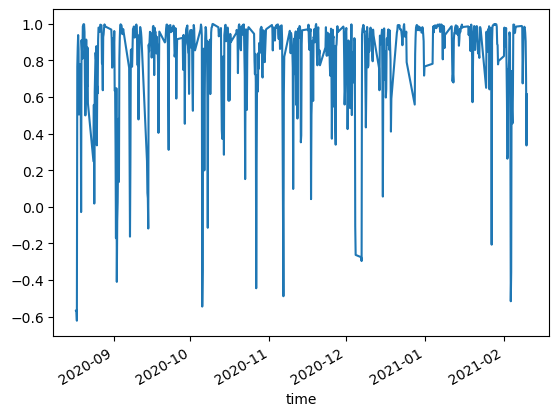

In [61]:
AU_NU = get_pair_correlations('AUDUSD.a', 'NZDUSD.a', 5)
AU_NU['rolling_corr'].iloc[0:750].plot()

In [74]:
AU_NU.corr()

,AUDUSD.a_close,NZDUSD.a_close,rolling_corr,AUDUSD.a_return,NZDUSD.a_return,diff,rolling_corr_returns,shifted_rolling_corr_returns
AUDUSD.a_close,1.000000,0.965848,0.003780,0.030595,0.025639,0.010837,-0.003965,-0.004412
NZDUSD.a_close,0.965848,1.000000,-0.020269,0.027497,0.027517,0.000012,0.010639,0.010365
rolling_corr,0.003780,-0.020269,1.000000,-0.003997,-0.007186,0.006927,-0.006935,0.021117
AUDUSD.a_return,0.030595,0.027497,-0.003997,1.000000,0.894367,0.231720,-0.025514,-0.008409
NZDUSD.a_return,0.025639,0.027517,-0.007186,0.894367,1.000000,-0.227915,0.025736,-0.008155
diff,0.010837,0.000012,0.006927,0.231720,-0.227915,1.000000,-0.111501,-0.000568
rolling_corr_returns,-0.003965,0.010639,-0.006935,-0.025514,0.025736,-0.111501,1.000000,0.598644
shifted_rolling_corr_returns,-0.004412,0.010365,0.021117,-0.008409,-0.008155,-0.000568,0.598644,1.000000


In [75]:
np.cov(AU_NU)

array([[ 0.26115327,  0.16260621,  0.16501692, ...,  0.09746161,
         0.01421638,  0.02092063],
       [ 0.16260621,  0.16480447,  0.17044062, ...,  0.00534735,
         0.0369558 , -0.00433707],
       [ 0.16501692,  0.17044062,  0.1772012 , ..., -0.00332087,
         0.03714966, -0.00650682],
       ...,
       [ 0.09746161,  0.00534735, -0.00332087, ...,  0.19983626,
         0.06579227,  0.13599403],
       [ 0.01421638,  0.0369558 ,  0.03714966, ...,  0.06579227,
         0.08902757,  0.09998917],
       [ 0.02092063, -0.00433707, -0.00650682, ...,  0.13599403,
         0.09998917,  0.15804439]])

<AxesSubplot:xlabel='time'>

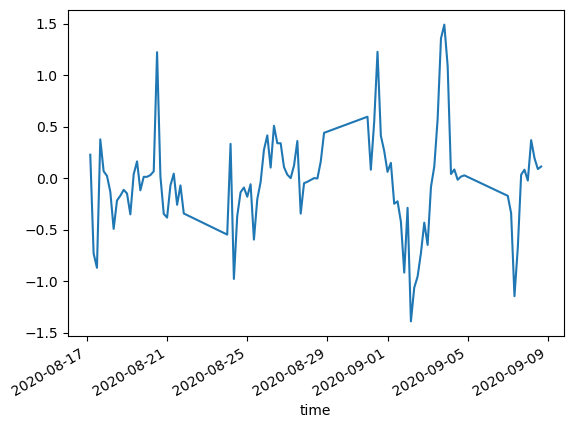

In [51]:
test = (AU_NU['rolling_corr'] - EU_GU['rolling_corr'])
test.iloc[0:100].plot()

## Volatility

In [77]:
import statistics

In [87]:
EU_GU['rolling_var'] = EU_GU['EURUSD.a_close'].rolling(window = 25).var()
EU_GU['shifted_var'] = EU_GU['rolling_var'].shift(1)
EU_GU = EU_GU.dropna()

C:\Users\markp\AppData\Local\Temp\ipykernel_12512\3912485532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EU_GU['rolling_var'] = EU_GU['EURUSD.a_close'].rolling(window = 25).var()
C:\Users\markp\AppData\Local\Temp\ipykernel_12512\3912485532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EU_GU['shifted_var'] = EU_GU['rolling_var'].shift(1)


In [95]:
EU_GU[['shifted_var', 'diff']]

,shifted_var,diff
time,,
2020-08-25 20:00:00,0.000009,-0.000295
2020-08-26 00:00:00,0.000008,0.000101
2020-08-26 04:00:00,0.000008,-0.000894
2020-08-26 08:00:00,0.000008,-0.001304
2020-08-26 12:00:00,0.000007,-0.000406
...,...,...
2023-10-27 04:00:00,0.000018,0.000023
2023-10-27 08:00:00,0.000018,0.000296
2023-10-27 12:00:00,0.000019,-0.000814


In [94]:
EU_GU[['shifted_var', 'diff']].corr()

,shifted_var,diff
shifted_var,1.000000,-0.008661
diff,-0.008661,1.000000


In [93]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(EU_GU[['shifted_var', 'diff']], 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.5936 , p=0.0000  , df_denom=4947, df_num=1
ssr based chi2 test:   chi2=17.6042 , p=0.0000  , df=1
likelihood ratio test: chi2=17.5730 , p=0.0000  , df=1
parameter F test:         F=17.5936 , p=0.0000  , df_denom=4947, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.6254  , p=0.0005  , df_denom=4944, df_num=2
ssr based chi2 test:   chi2=15.2663 , p=0.0005  , df=2
likelihood ratio test: chi2=15.2428 , p=0.0005  , df=2
parameter F test:         F=7.6254  , p=0.0005  , df_denom=4944, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5333  , p=0.0001  , df_denom=4941, df_num=3
ssr based chi2 test:   chi2=22.6318 , p=0.0000  , df=3
likelihood ratio test: chi2=22.5802 , p=0.0000  , df=3
parameter F test:         F=7.5333  , p=0.0001  , df_denom=4941, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.9382  , p=0.

{1: ({'ssr_ftest': (17.593569288270537, 2.7829744290187754e-05, 4947.0, 1),
   'ssr_chi2test': (17.60423852373947, 2.719814839331614e-05, 1),
   'lrtest': (17.573008585182833, 2.764849733692958e-05, 1),
   'params_ftest': (17.593569288271233, 2.782974429017248e-05, 4947.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (7.625430681520601, 0.0004936451352256021, 4944.0, 2),
   'ssr_chi2test': (15.266284968788614, 0.0004841370721632451, 2),
   'lrtest': (15.242787163122557, 0.0004898586971740638, 2),
   'params_ftest': (7.62543068148382, 0.0004936451352438352, 4944.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.533255815021851, 5.010150177554462e-05, 4941.0, 3),
   'ssr_chi2test': (22.63178492576085, 4.8186359035413456e-05, 3),
   'lrtest': (22.580184158694465, 4.939378836333214e-05, 3),
   'params_ftest': (7.533255815021984, 5.010150177553972e-05, 4941.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0.,